## Importing necessary Libraries and Functions

In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split


## Reading Data

In [339]:
df = pd.read_excel("premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [340]:
df.shape

(50000, 13)

In [341]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


## EDA and Data Cleaning

In [342]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [343]:
df.dropna(inplace=True)

In [344]:
df.duplicated().sum()

0

In [345]:
df.drop_duplicates(inplace=True)

### Exploring Statistics

In [346]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [347]:
df[df.number_of_dependants<0].shape

(72, 13)

In [348]:
df[df.number_of_dependants<0]["number_of_dependants"].unique()

array([-3, -1], dtype=int64)

In [349]:
df["number_of_dependants"] = abs(df["number_of_dependants"])

In [350]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Outlier treatment in numeric columns

In [351]:
numeric_columns = df.select_dtypes(["int64", "float64"]).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

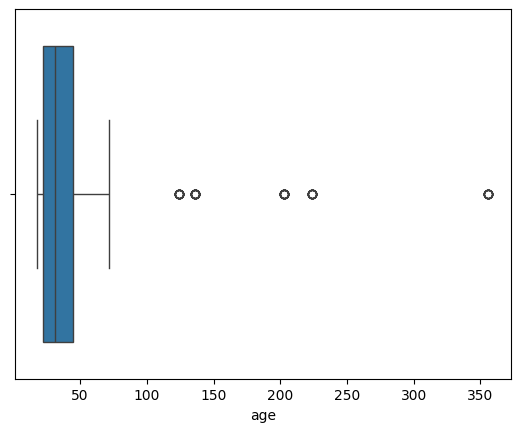

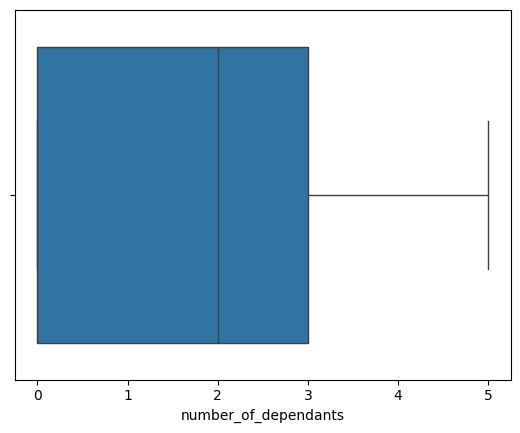

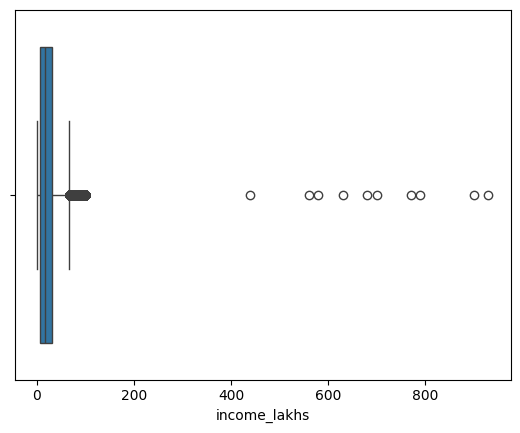

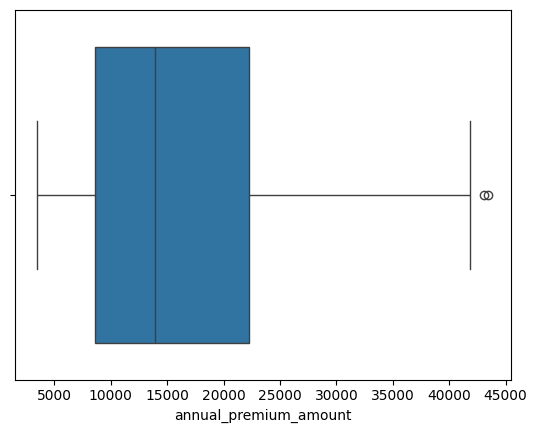

In [352]:
for col in numeric_columns:
    sns.boxplot(x = df[col])
    plt.show()

In [353]:
df[df.age>100]["age"].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [354]:
df1 = df[df.age<=100].copy()

In [355]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [356]:
def get_iqr_bounds(col):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

In [357]:
lower_bound, upper_bound = get_iqr_bounds(df1.income_lakhs)
print(lower_bound, upper_bound)

-29.0 67.0


In [358]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [359]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()

In [360]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


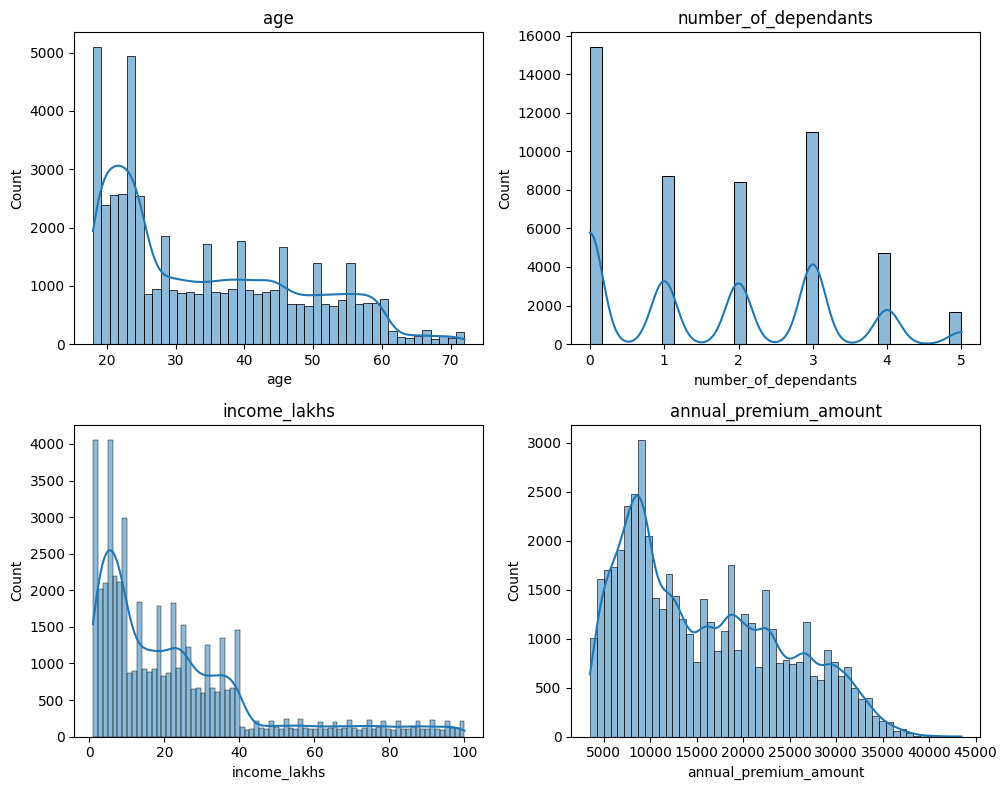

In [361]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # <--- this is the part you asked about
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='annual_premium_amount'>

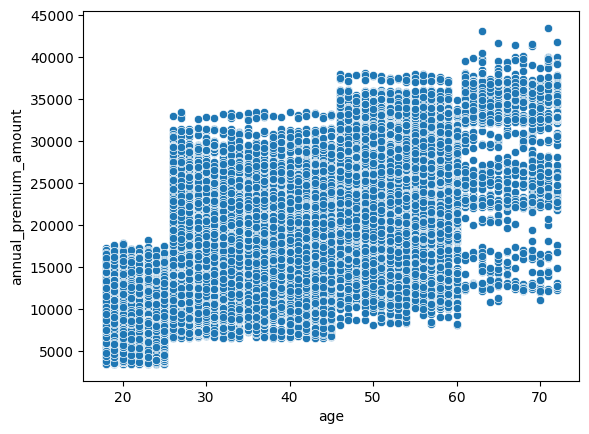

In [362]:
sns.scatterplot(df2, x = "age", y="annual_premium_amount")

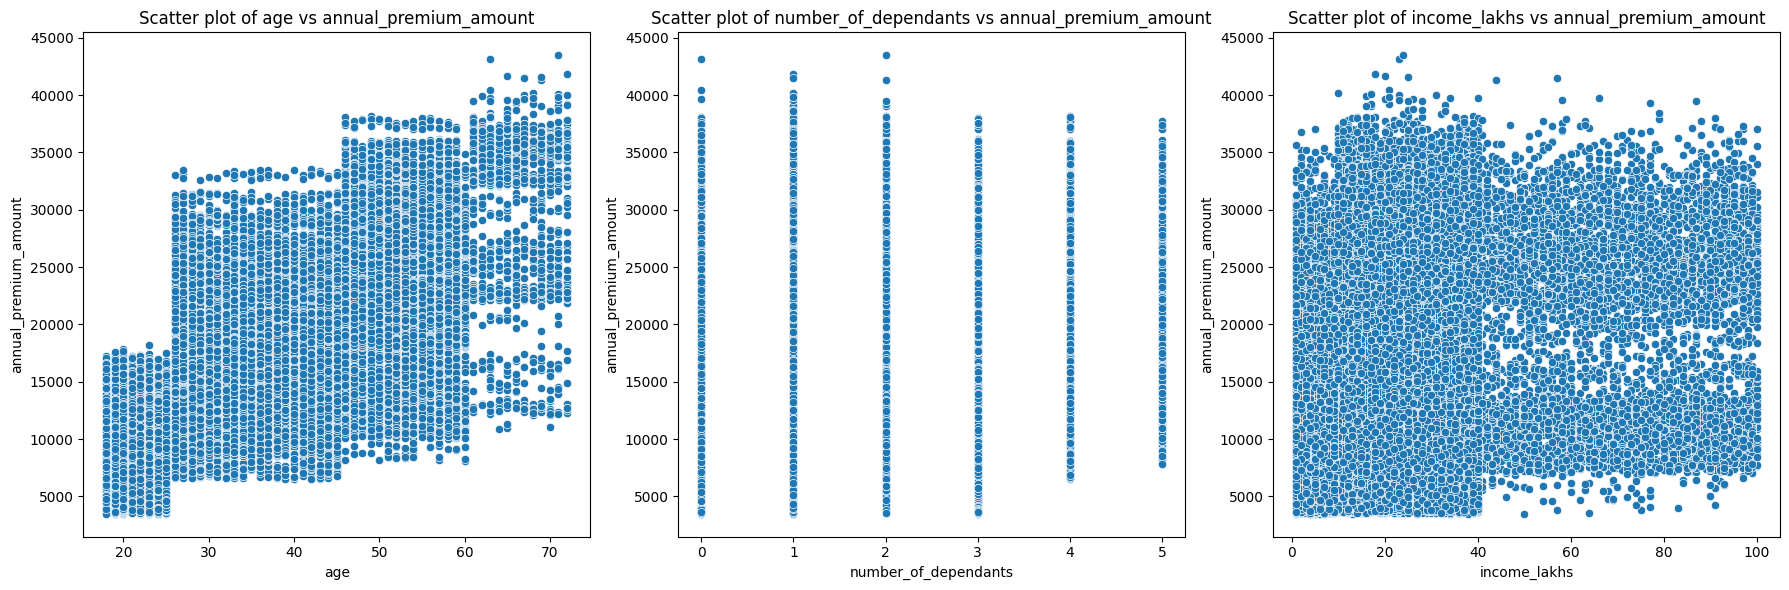

In [363]:
numeric_columns = list(numeric_columns)
numeric_columns.remove("annual_premium_amount")
fig, axs = plt.subplots(nrows= 1, ncols=len(numeric_columns), figsize = (18,6))
for i, col in enumerate(numeric_columns):
    index = i
    ax = axs[index]
    sns.scatterplot(df2, x = col, y="annual_premium_amount",ax = ax)
    ax.set_title(f"Scatter plot of {col} vs annual_premium_amount")
plt.tight_layout()
plt.show()

## Feature Engineering

### Data cleaning and preprocessing on Categorical Columns

In [364]:
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [365]:
for col in (categorical_columns):
    print(f"col_name:{col} - unique_values:{df[col].unique()}")

col_name:gender - unique_values:['Male' 'Female']
col_name:region - unique_values:['Northwest' 'Southeast' 'Northeast' 'Southwest']
col_name:marital_status - unique_values:['Unmarried' 'Married']
col_name:bmi_category - unique_values:['Normal' 'Obesity' 'Overweight' 'Underweight']
col_name:smoking_status - unique_values:['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
col_name:employment_status - unique_values:['Salaried' 'Self-Employed' 'Freelancer']
col_name:income_level - unique_values:['<10L' '10L - 25L' '> 40L' '25L - 40L']
col_name:medical_history - unique_values:['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
col_name:insurance_plan - unique_values:['Bronze' 'Silver' 'Gold']


In [366]:
df2["smoking_status"].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
}, inplace = True)
df2["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13676\4132920689.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13676\4132920689.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13676\4132920689.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13676\4132920689.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotat

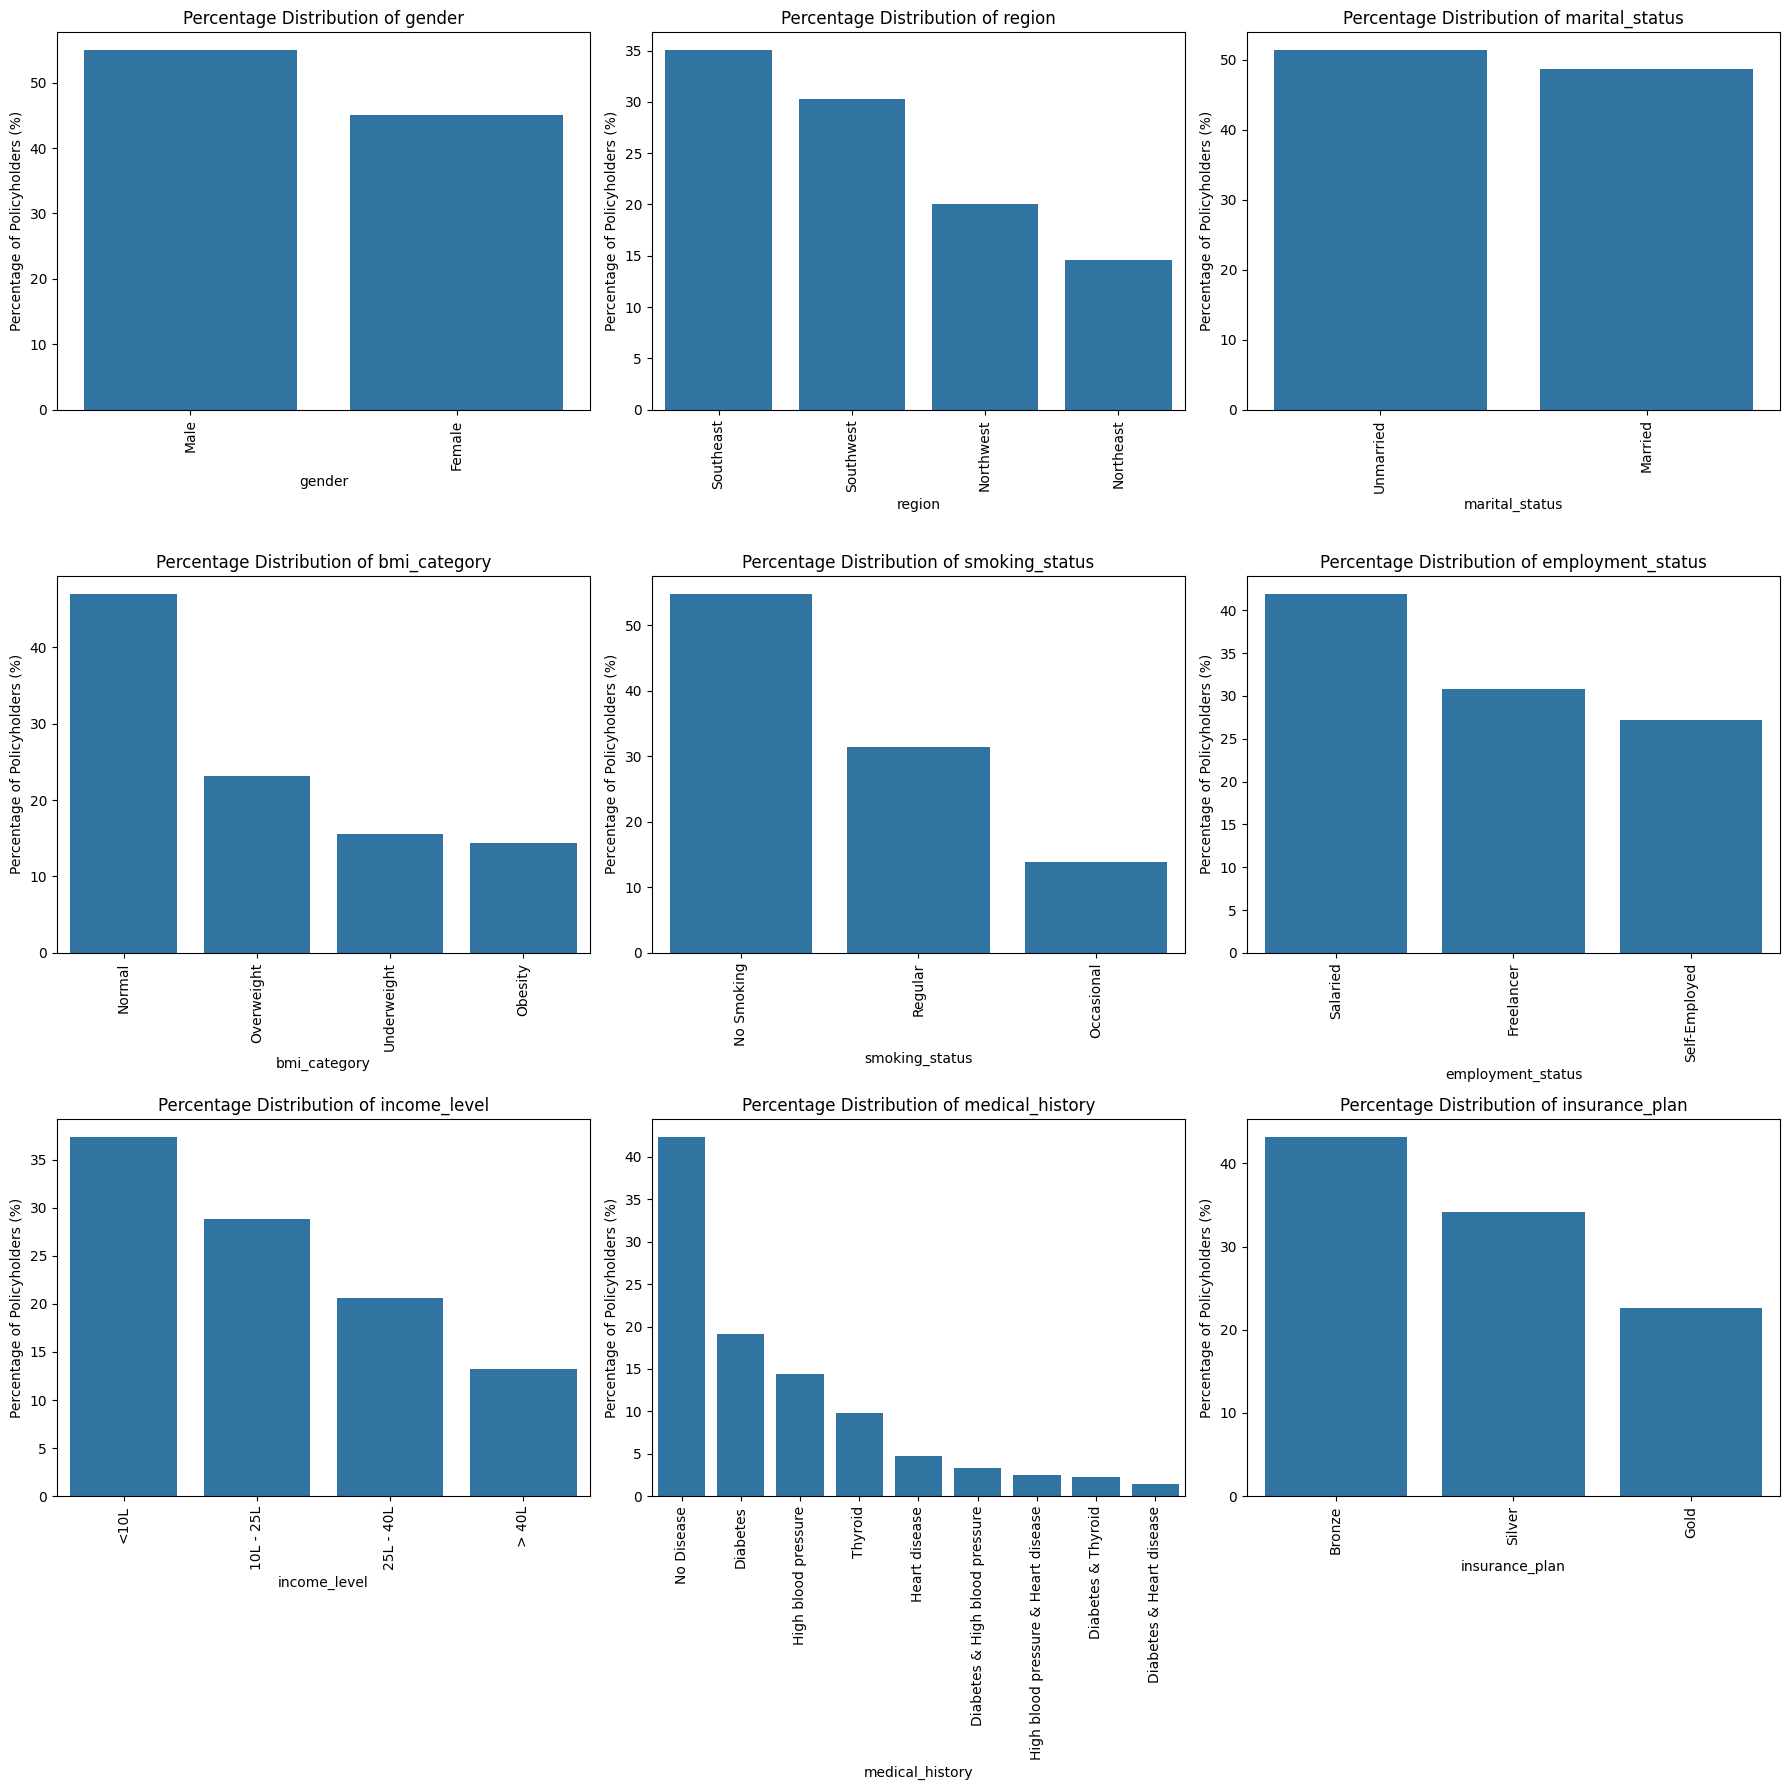

In [367]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_columns):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xLabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()


In [368]:
cross_tab = pd.crosstab(df2["income_level"], df2["insurance_plan"])

In [369]:
print(cross_tab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


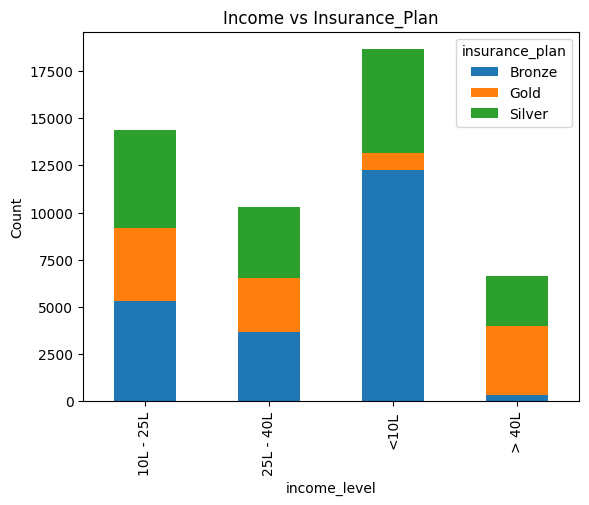

In [370]:
cross_tab.plot(kind="bar", stacked = True)
plt.ylabel("Count")
plt.title("Income vs Insurance_Plan")
plt.show()

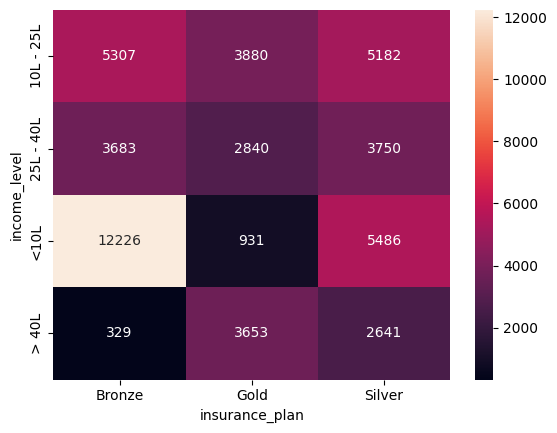

In [371]:
sns.heatmap(cross_tab, annot=True, fmt='d')
plt.show()

In [372]:
df2["medical_history"].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [373]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}
df2['medical_history'].str.split(" & ", expand=True)

,0,1
0,Diabetes,None
1,Diabetes,None
2,High blood pressure,None
3,No Disease,None
4,High blood pressure,None
...,...,...
49995,No Disease,None
49996,Thyroid,None
49997,No Disease,None
49998,No Disease,None


In [374]:
df2[["disease1", "disease2"]] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

In [375]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None


In [376]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0


In [377]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,0


In [378]:
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

In [379]:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)

In [380]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


In [381]:
df.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [382]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2['income_level'] = df2['income_level'].map({
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4
})


In [383]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [384]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)

df3.head()


,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [385]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


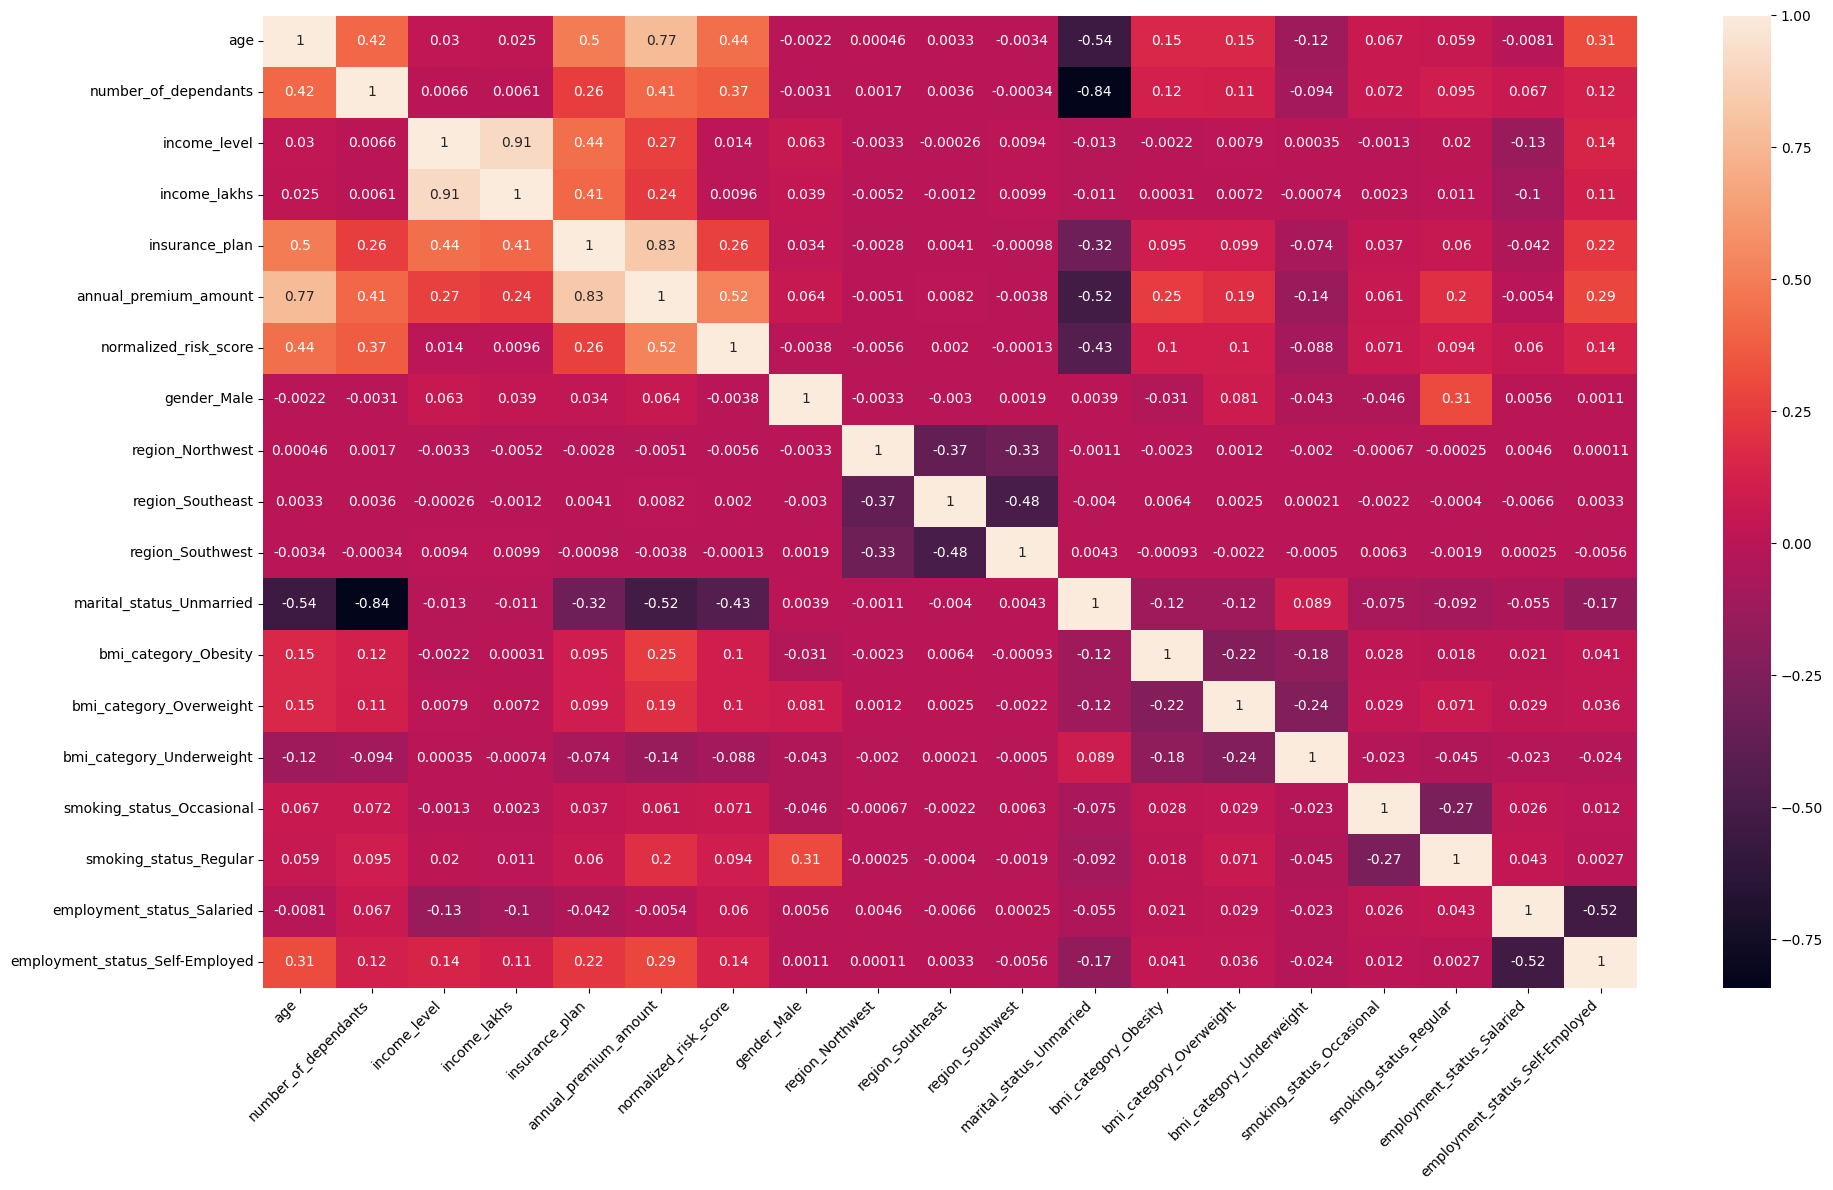

In [386]:
cm = df4.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [387]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']
from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [388]:
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Handling multicollinearity using VIF

In [389]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Columns"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [390]:
vif_df = calculate_vif(X)

In [391]:
vif_df

,Columns,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [392]:
vif_df = calculate_vif(X.drop(["income_level"], axis =1))
vif_df

,Columns,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [393]:
X_reduced = X.drop("income_level", axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


## Model Training

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

In [395]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.9280547230217837

In [396]:
model.score(X_train,y_train)

0.9282143576916762

In [397]:
feature_importance = model.coef_
coef_df = pd.DataFrame(feature_importance, index = X_test.columns, columns=["Coefficients"])
coef_df = coef_df.sort_values(by=["Coefficients"], ascending=True)

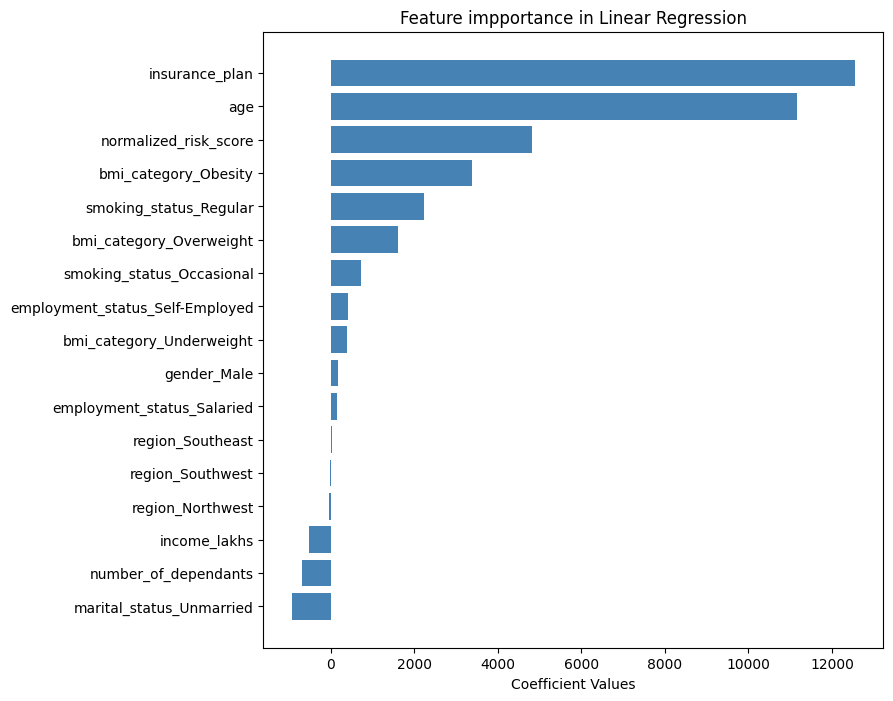

In [398]:
plt.figure(figsize=(8,8))
plt.barh(coef_df.index, coef_df["Coefficients"], color = 'steelblue')
plt.xlabel("Coefficient Values")
plt.title("Feature impportance in Linear Regression")
plt.show()

In [399]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)
model_ridge.score(X_test,y_test)

0.9280541644640345

In [400]:
from xgboost import XGBRegressor
model_xgb =XGBRegressor()
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test,y_test)

0.9809534549713135

In [401]:
model_xgb = XGBRegressor()

param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

random_search = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(random_search.best_score_)
print(random_search.best_params_)

best_model = random_search.best_estimator_


0.9809474547704061
{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


In [402]:
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)


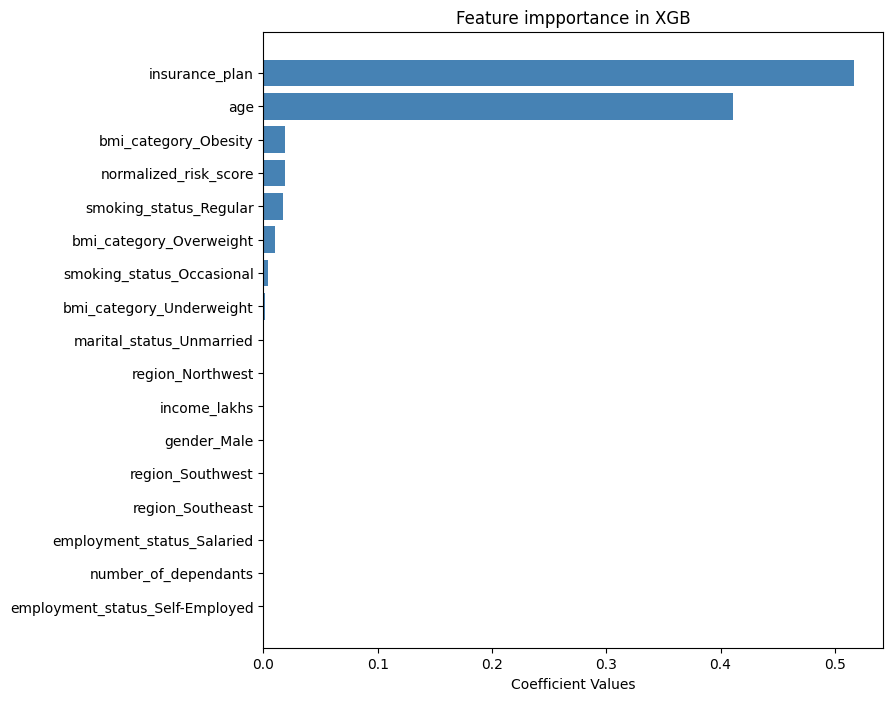

In [403]:
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importance, index = X_test.columns, columns=["Coefficients"])
coef_df = coef_df.sort_values(by=["Coefficients"], ascending=True)
plt.figure(figsize=(8,8))
plt.barh(coef_df.index, coef_df["Coefficients"], color = 'steelblue')
plt.xlabel("Coefficient Values")
plt.title("Feature impportance in XGB")
plt.show()

## Error Analysis

In [404]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

In [405]:
results_df = pd.DataFrame({
    'Actual':y_test,
    'Predicted': y_pred,
    'Residulas': residuals,
    'Residuals_pct' :residuals_pct
})

In [406]:
results_df.head()

,Actual,Predicted,Residulas,Residuals_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


<Axes: xlabel='Residuals_pct', ylabel='Count'>

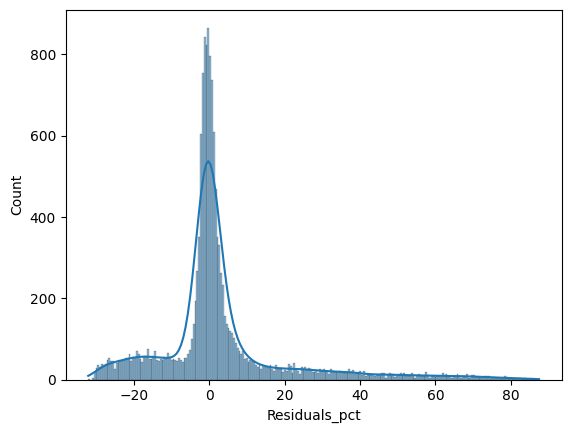

In [407]:
sns.histplot(data=results_df, x="Residuals_pct", kde= True)

In [408]:
threshold = 10
extreme_results_df = results_df[abs(results_df.Residuals_pct)>threshold]

In [409]:
extreme_results_pct = print(100*extreme_results_df.shape[0]/results_df.shape[0])

29.967274427302478


In [410]:
very_extreme_results_df = results_df[abs(results_df.Residuals_pct)>50].sort_values("Residuals_pct", ascending = False)

In [411]:
very_extreme_results_df.head()

,Actual,Predicted,Residulas,Residuals_pct
36269,3501,6565.852051,3064.852051,87.542189
48801,3516,6565.852051,3049.852051,86.742095
42342,3521,6565.852051,3044.852051,86.476911
18564,3523,6565.852051,3042.852051,86.371049
7988,3527,6565.852051,3038.852051,86.159684


In [413]:
extreme_error_df = X_test.loc[extreme_results_df.index]

In [414]:
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


In [418]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

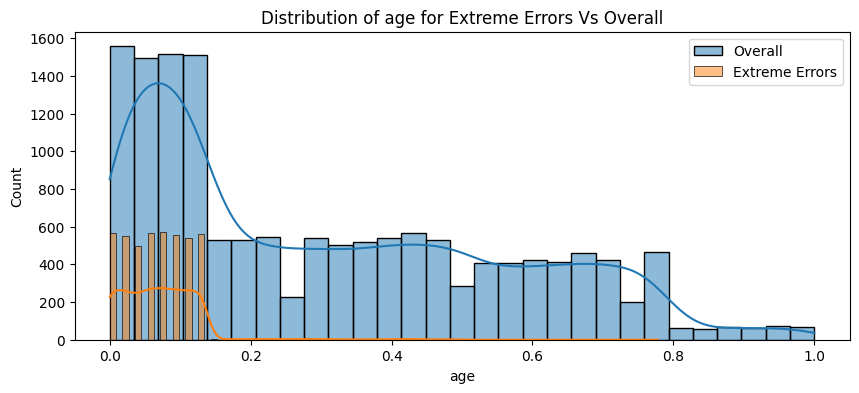

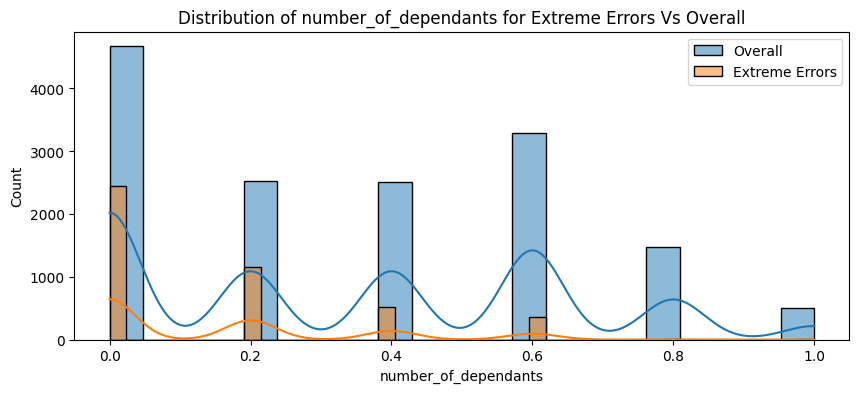

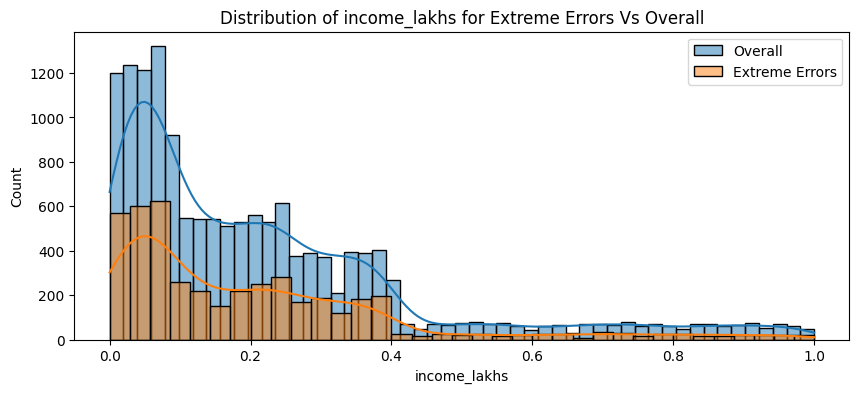

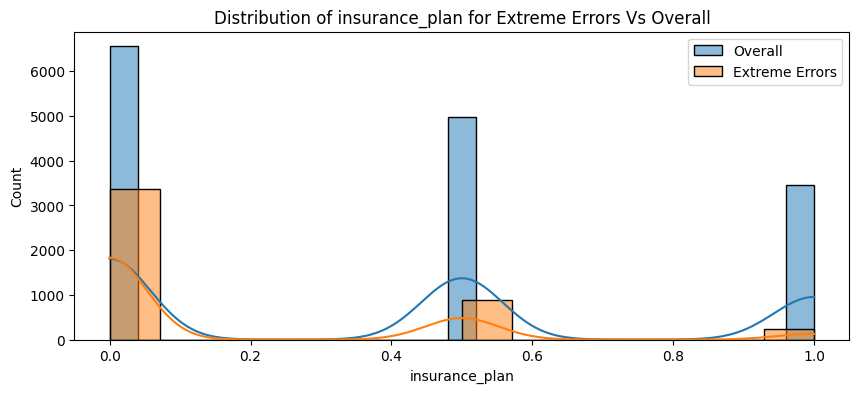

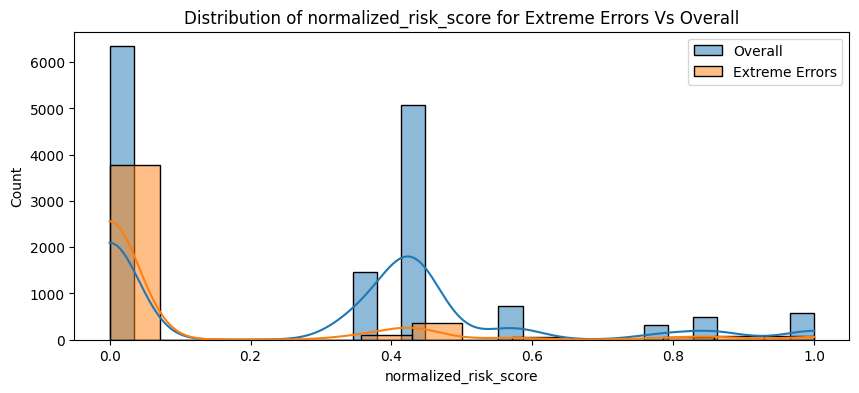

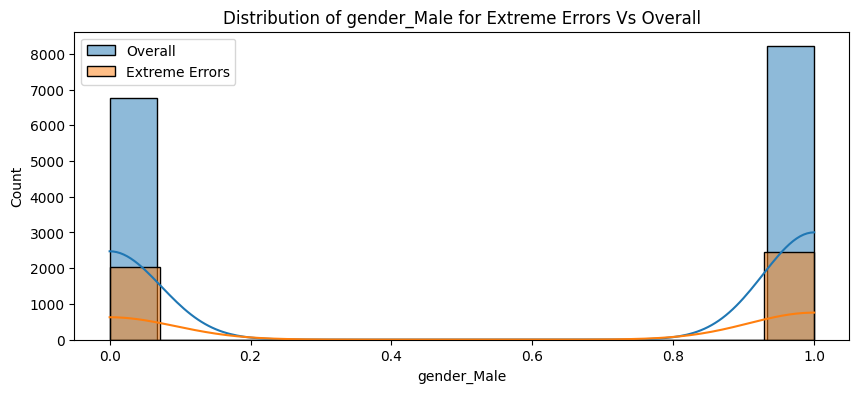

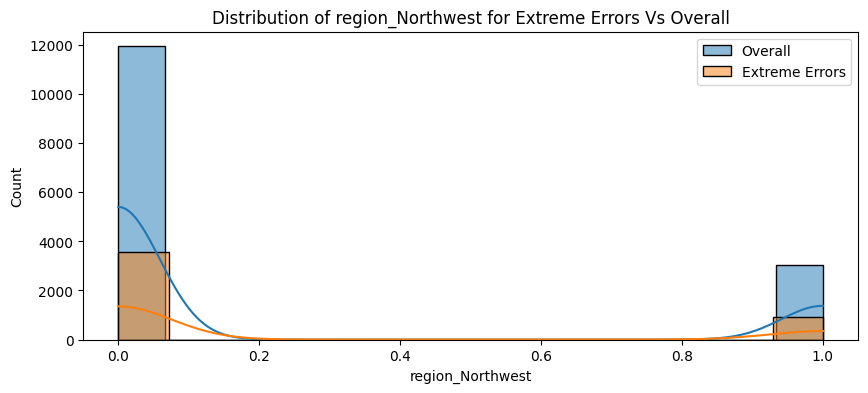

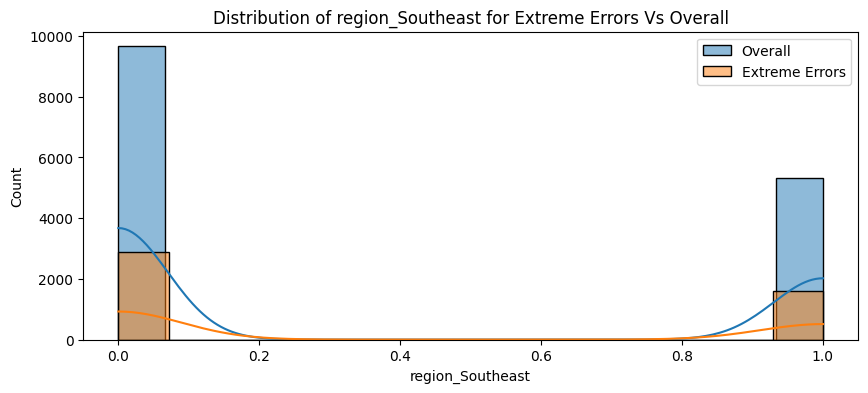

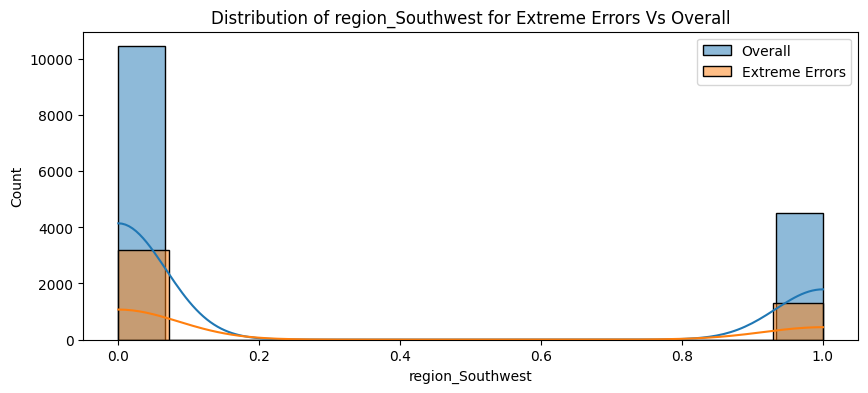

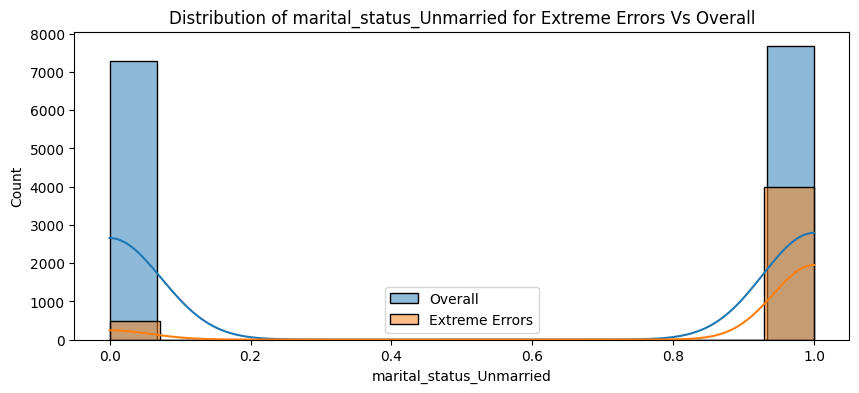

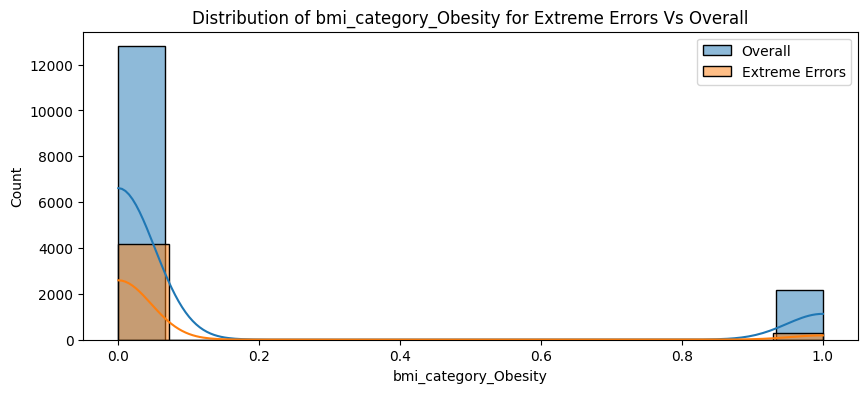

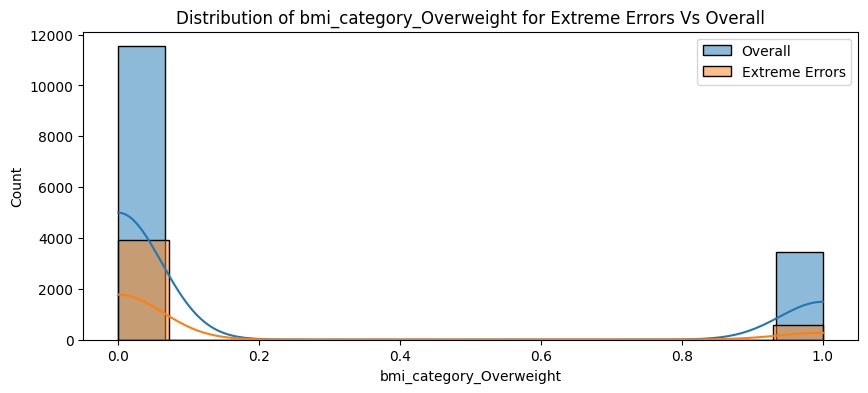

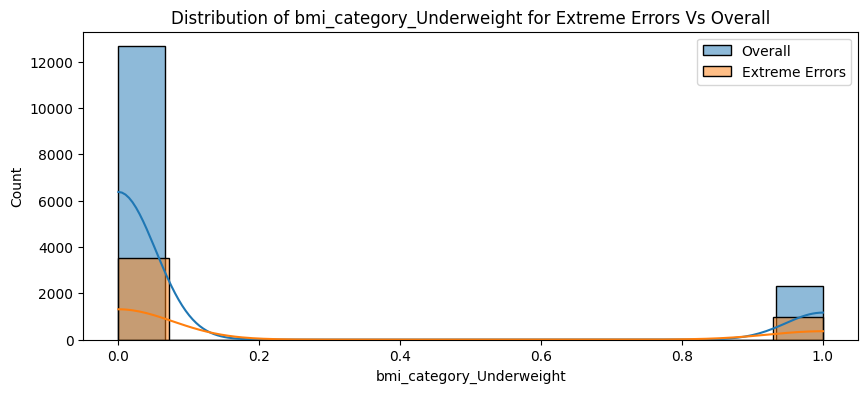

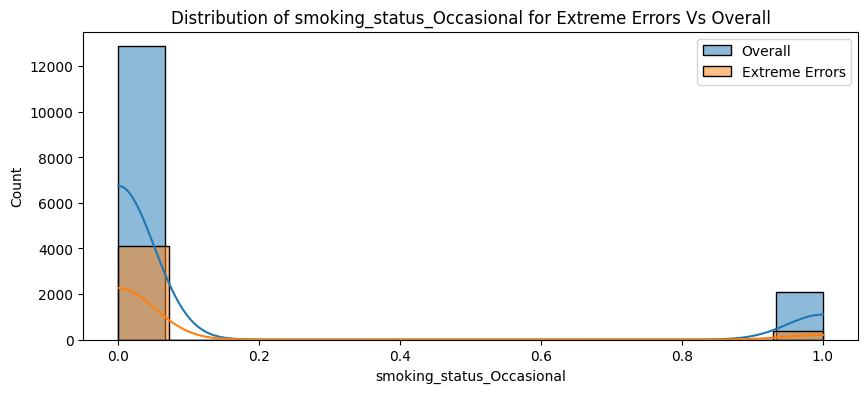

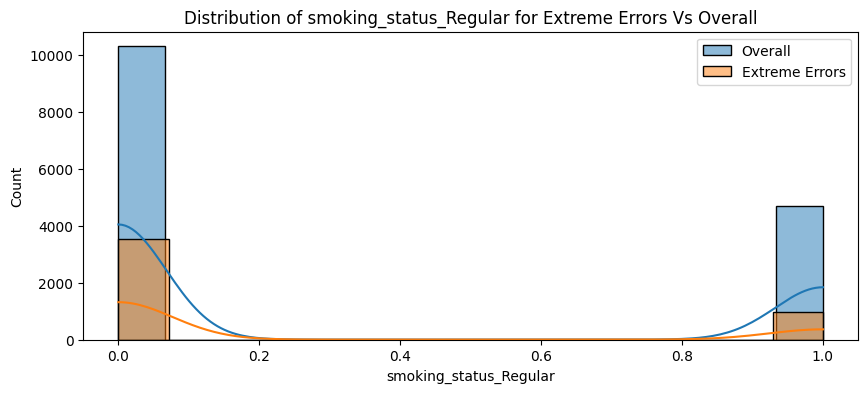

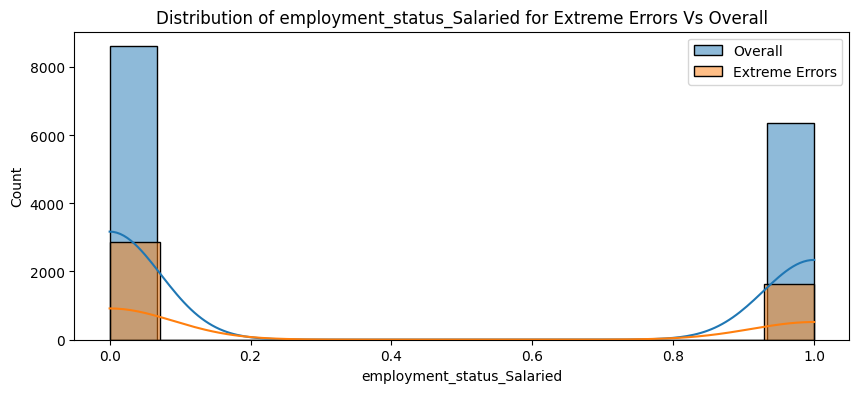

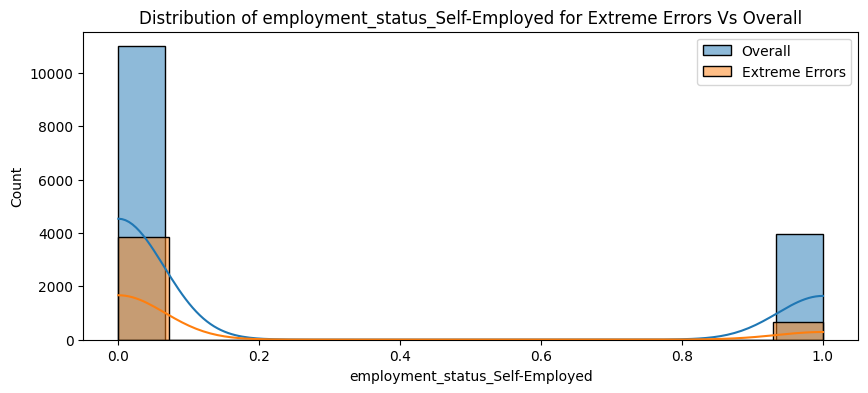

In [421]:
for feature in list(X_test.columns):
    plt.figure(figsize=(10, 4))
    sns.histplot(X_test[feature], label = "Overall", kde=True)
    sns.histplot(extreme_error_df[feature], label = "Extreme Errors",kde=True)
    plt.title(f"Distribution of {feature} for Extreme Errors Vs Overall")
    plt.legend()
    plt.show()

In [433]:
df_reversed = pd.DataFrame()
extreme_error_df['income_level'] = -1
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])

<Axes: xlabel='age', ylabel='Count'>

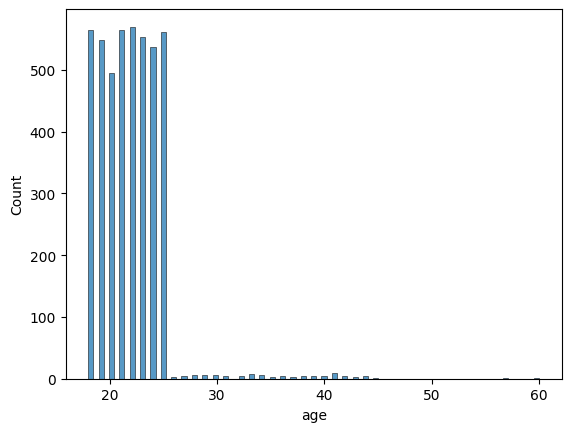

In [434]:
sns.histplot(df_reversed["age"])

In [435]:
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


In [436]:
df_reversed["age"].quantile(.97)

25.0

### Extreme error is concentrated in lower age group 